# Scikit-learn → ONNX Benchmarking

Chuyển đổi các models từ **Scikit-learn** sang ONNX format và benchmark performance trên CPU.

## Models
1. **RandomForestClassifier** - Iris dataset
2. **LogisticRegression** - Iris dataset  
3. **SVM (SVC)** - Iris dataset
4. **MLPClassifier** - Iris dataset

## Comparison Metrics
- Inference time (ms)
- Throughput (predictions/sec)
- Model size (KB)
- Accuracy comparison (Sklearn vs ONNX)
- Speedup factor

## 1. Setup Environment

In [1]:
import sys
print(f'Python version: {sys.version}')

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [2]:
!pip install -q onnx onnxruntime onnxmltools skl2onnx
!pip install -q scikit-learn matplotlib seaborn pandas numpy

## 2. Import Libraries

In [3]:
import numpy as np
import pandas as pd
import onnx
import onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Print versions
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Scikit-learn version: {__import__("sklearn").__version__}')
print(f'ONNX version: {onnx.__version__}')
print(f'ONNX Runtime version: {ort.__version__}')
print(f'ONNX Runtime providers: {ort.get_available_providers()}')

NumPy version: 1.26.4
Pandas version: 2.2.2
Scikit-learn version: 1.6.1
ONNX version: 1.20.1
ONNX Runtime version: 1.23.2
ONNX Runtime providers: ['AzureExecutionProvider', 'CPUExecutionProvider']


## 3. Create Directories

In [4]:
os.makedirs('models/sklearn', exist_ok=True)
os.makedirs('results', exist_ok=True)
print('Directories created successfully!')
print(f'  - models/sklearn/')
print(f'  - results/')

Directories created successfully!
  - models/sklearn/
  - results/


## 4. Load and Prepare Dataset

In [5]:
print('='*60)
print('Loading Iris Dataset')
print('='*60)

# Load iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f'Dataset: {iris.filename}')
print(f'Features: {iris.feature_names}')
print(f'Target classes: {iris.target_names}')
print(f'Total samples: {len(X)}')
print(f'Training samples: {len(X_train)}')
print(f'Test samples: {len(X_test)}')
print(f'Feature shape: {X.shape}')
print(f'Number of classes: {len(np.unique(y))}')

Loading Iris Dataset
Dataset: iris.csv
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target classes: ['setosa' 'versicolor' 'virginica']
Total samples: 150
Training samples: 105
Test samples: 45
Feature shape: (150, 4)
Number of classes: 3


## 5. Train Models

### 5.1 RandomForest Classifier

In [6]:
print('='*60)
print('Training RandomForest Classifier')
print('='*60)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f'Training completed!')
print(f'Test Accuracy: {rf_accuracy:.4f}')
print(f'Number of trees: {rf_model.n_estimators}')
print(f'Max depth: {rf_model.max_depth}')

Training RandomForest Classifier
Training completed!
Test Accuracy: 0.8889
Number of trees: 100
Max depth: 5


### 5.2 Logistic Regression

In [7]:
print('='*60)
print('Training Logistic Regression')
print('='*60)

lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train, y_train)

# Evaluate
y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f'Training completed!')
print(f'Test Accuracy: {lr_accuracy:.4f}')
print(f'Number of iterations: {lr_model.n_iter_}')

Training Logistic Regression
Training completed!
Test Accuracy: 0.9333
Number of iterations: [109]


### 5.3 Support Vector Machine (SVC)

In [8]:
print('='*60)
print('Training SVM (SVC)')
print('='*60)

svm_model = SVC(kernel='rbf', gamma='auto', random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

print(f'Training completed!')
print(f'Test Accuracy: {svm_accuracy:.4f}')
print(f'Kernel: {svm_model.kernel}')
print(f'Number of support vectors: {len(svm_model.support_vectors_)}')

Training SVM (SVC)
Training completed!
Test Accuracy: 0.9778
Kernel: rbf
Number of support vectors: 35


### 5.4 Multi-Layer Perceptron (MLP)

In [9]:
print('='*60)
print('Training MLP Classifier')
print('='*60)

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)

# Evaluate
y_pred_mlp = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)

print(f'Training completed!')
print(f'Test Accuracy: {mlp_accuracy:.4f}')
print(f'Hidden layers: {mlp_model.hidden_layer_sizes}')
print(f'Number of iterations: {mlp_model.n_iter_}')

Training MLP Classifier
Training completed!
Test Accuracy: 0.9778
Hidden layers: (100, 50)
Number of iterations: 300


## 6. Convert Models to ONNX

### 6.1 RandomForest → ONNX

In [10]:
print('='*60)
print('Converting RandomForest → ONNX')
print('='*60)

# Define input type
initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]

# Convert to ONNX
rf_onnx_path = 'models/sklearn/random_forest.onnx'
rf_onnx = convert_sklearn(rf_model, initial_types=initial_type, target_opset=18)

# Save
with open(rf_onnx_path, 'wb') as f:
    f.write(rf_onnx.SerializeToString())

size_kb = os.path.getsize(rf_onnx_path) / 1024
print(f'✅ Saved: {rf_onnx_path} ({size_kb:.2f} KB)')

Converting RandomForest → ONNX
✅ Saved: models/sklearn/random_forest.onnx (59.14 KB)


### 6.2 Logistic Regression → ONNX

In [11]:
print('='*60)
print('Converting Logistic Regression → ONNX')
print('='*60)

lr_onnx_path = 'models/sklearn/logistic_regression.onnx'
lr_onnx = convert_sklearn(lr_model, initial_types=initial_type, target_opset=18)

with open(lr_onnx_path, 'wb') as f:
    f.write(lr_onnx.SerializeToString())

size_kb = os.path.getsize(lr_onnx_path) / 1024
print(f'✅ Saved: {lr_onnx_path} ({size_kb:.2f} KB)')

Converting Logistic Regression → ONNX
✅ Saved: models/sklearn/logistic_regression.onnx (0.68 KB)


### 6.3 SVM → ONNX

In [12]:
print('='*60)
print('Converting SVM → ONNX')
print('='*60)

svm_onnx_path = 'models/sklearn/svm.onnx'
svm_onnx = convert_sklearn(svm_model, initial_types=initial_type, target_opset=18)

with open(svm_onnx_path, 'wb') as f:
    f.write(svm_onnx.SerializeToString())

size_kb = os.path.getsize(svm_onnx_path) / 1024
print(f'✅ Saved: {svm_onnx_path} ({size_kb:.2f} KB)')

Converting SVM → ONNX
✅ Saved: models/sklearn/svm.onnx (3.07 KB)


### 6.4 MLP → ONNX

In [13]:
print('='*60)
print('Converting MLP → ONNX')
print('='*60)

mlp_onnx_path = 'models/sklearn/mlp.onnx'
mlp_onnx = convert_sklearn(mlp_model, initial_types=initial_type, target_opset=18)

with open(mlp_onnx_path, 'wb') as f:
    f.write(mlp_onnx.SerializeToString())

size_kb = os.path.getsize(mlp_onnx_path) / 1024
print(f'✅ Saved: {mlp_onnx_path} ({size_kb:.2f} KB)')

Converting MLP → ONNX
✅ Saved: models/sklearn/mlp.onnx (23.66 KB)


## 7. Validate ONNX Models

In [14]:
print('='*60)
print('Validating ONNX Models')
print('='*60)

models_to_validate = {
    'RandomForest': rf_onnx_path,
    'LogisticRegression': lr_onnx_path,
    'SVM': svm_onnx_path,
    'MLP': mlp_onnx_path
}

for name, path in models_to_validate.items():
    onnx_model = onnx.load(path)
    onnx.checker.check_model(onnx_model)
    print(f'✅ {name}: Valid ONNX model')

print('\nAll models validated successfully!')

Validating ONNX Models
✅ RandomForest: Valid ONNX model
✅ LogisticRegression: Valid ONNX model
✅ SVM: Valid ONNX model
✅ MLP: Valid ONNX model

All models validated successfully!


## 8. ONNX Inference Class

In [15]:
class ONNXInference:
    """ONNX Runtime Inference for Sklearn models"""

    def __init__(self, onnx_path: str):
        # Create inference session (CPU only for sklearn models)
        sess_options = ort.SessionOptions()
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

        self.session = ort.InferenceSession(
            onnx_path,
            providers=['CPUExecutionProvider'],
            sess_options=sess_options
        )

        # Get input/output metadata
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name

        print(f'Model loaded: {os.path.basename(onnx_path)}')
        print(f'Input: {self.input_name}')
        print(f'Output: {self.output_name}')

    def predict(self, X: np.ndarray):
        """Run prediction"""
        if X.dtype != np.float32:
            X = X.astype(np.float32)
        return self.session.run([self.output_name], {self.input_name: X})[0]

    def benchmark(self, X: np.ndarray, num_runs: int = 1000, warmup: int = 100):
        """Benchmark inference performance"""
        # Warmup
        for _ in range(warmup):
            self.predict(X)

        # Benchmark
        times = []
        for _ in range(num_runs):
            start = time.time()
            self.predict(X)
            times.append(time.time() - start)

        # Calculate statistics
        mean_time = np.mean(times) * 1000  # Convert to ms
        std_time = np.std(times) * 1000
        throughput = 1000.0 / mean_time * len(X)  # predictions per second

        return {
            'mean': mean_time,
            'std': std_time,
            'throughput': throughput,
            'min': np.min(times) * 1000,
            'max': np.max(times) * 1000
        }

print('ONNXInference class defined successfully!')

ONNXInference class defined successfully!


## 9. Benchmark All Models

### 9.1 Sklearn Native Benchmarking

In [16]:
print('='*60)
print('Benchmarking Sklearn Models (Native)')
print('='*60)

X_test_float = X_test.astype(np.float32)
sklearn_results = {}
num_runs = 1000
warmup = 100

models_sklearn = {
    'RandomForest': rf_model,
    'LogisticRegression': lr_model,
    'SVM': svm_model,
    'MLP': mlp_model
}

for name, model in models_sklearn.items():
    print(f'\nBenchmarking {name}...')

    # Warmup
    for _ in range(warmup):
        model.predict(X_test_float)

    # Benchmark
    times = []
    for _ in range(num_runs):
        start = time.time()
        model.predict(X_test_float)
        times.append(time.time() - start)

    mean_time = np.mean(times) * 1000
    std_time = np.std(times) * 1000
    throughput = 1000.0 / mean_time * len(X_test)

    sklearn_results[name] = {
        'mean': mean_time,
        'std': std_time,
        'throughput': throughput,
        'min': np.min(times) * 1000,
        'max': np.max(times) * 1000
    }

    print(f'{name}: {mean_time:.4f} ± {std_time:.4f} ms, {throughput:.0f} predictions/sec')

print('\n✅ Sklearn benchmarking completed!')

Benchmarking Sklearn Models (Native)

Benchmarking RandomForest...
RandomForest: 7.2604 ± 6.3456 ms, 6198 predictions/sec

Benchmarking LogisticRegression...
LogisticRegression: 0.4990 ± 0.9926 ms, 90189 predictions/sec

Benchmarking SVM...
SVM: 0.7788 ± 0.8335 ms, 57782 predictions/sec

Benchmarking MLP...
MLP: 0.7465 ± 1.1519 ms, 60285 predictions/sec

✅ Sklearn benchmarking completed!


### 9.2 ONNX Runtime Benchmarking

In [17]:
print('='*60)
print('Benchmarking ONNX Runtime Models')
print('='*60)

onnx_results = {}
models_onnx = {
    'RandomForest': rf_onnx_path,
    'LogisticRegression': lr_onnx_path,
    'SVM': svm_onnx_path,
    'MLP': mlp_onnx_path
}

for name, path in models_onnx.items():
    print(f'\n{name}:')
    onnx_model = ONNXInference(path)
    results = onnx_model.benchmark(X_test_float, num_runs=num_runs, warmup=warmup)
    onnx_results[name] = results
    print(f'Performance: {results["mean"]:.4f} ± {results["std"]:.4f} ms, {results["throughput"]:.0f} predictions/sec')

print('\n✅ ONNX benchmarking completed!')

Benchmarking ONNX Runtime Models

RandomForest:
Model loaded: random_forest.onnx
Input: float_input
Output: output_label
Performance: 0.1679 ± 0.0182 ms, 267965 predictions/sec

LogisticRegression:
Model loaded: logistic_regression.onnx
Input: float_input
Output: output_label
Performance: 0.0340 ± 0.0226 ms, 1323106 predictions/sec

SVM:
Model loaded: svm.onnx
Input: float_input
Output: label
Performance: 0.0487 ± 0.0054 ms, 923752 predictions/sec

MLP:
Model loaded: mlp.onnx
Input: float_input
Output: output_label
Performance: 0.0481 ± 0.0202 ms, 934837 predictions/sec

✅ ONNX benchmarking completed!


## 10. Accuracy Verification

In [18]:
print('='*60)
print('Verifying ONNX Model Accuracy')
print('='*60)

accuracy_comparison = {}

# RandomForest
rf_onnx_inf = ONNXInference(rf_onnx_path)
rf_onnx_pred = rf_onnx_inf.predict(X_test_float)
rf_onnx_accuracy = accuracy_score(y_test, rf_onnx_pred)
accuracy_comparison['RandomForest'] = {'sklearn': rf_accuracy, 'onnx': rf_onnx_accuracy}

# LogisticRegression
lr_onnx_inf = ONNXInference(lr_onnx_path)
lr_onnx_pred = lr_onnx_inf.predict(X_test_float)
lr_onnx_accuracy = accuracy_score(y_test, lr_onnx_pred)
accuracy_comparison['LogisticRegression'] = {'sklearn': lr_accuracy, 'onnx': lr_onnx_accuracy}

# SVM
svm_onnx_inf = ONNXInference(svm_onnx_path)
svm_onnx_pred = svm_onnx_inf.predict(X_test_float)
svm_onnx_accuracy = accuracy_score(y_test, svm_onnx_pred)
accuracy_comparison['SVM'] = {'sklearn': svm_accuracy, 'onnx': svm_onnx_accuracy}

# MLP
mlp_onnx_inf = ONNXInference(mlp_onnx_path)
mlp_onnx_pred = mlp_onnx_inf.predict(X_test_float)
mlp_onnx_accuracy = accuracy_score(y_test, mlp_onnx_pred)
accuracy_comparison['MLP'] = {'sklearn': mlp_accuracy, 'onnx': mlp_onnx_accuracy}

print(f'{"Model":<20} {"Sklearn Accuracy":<20} {"ONNX Accuracy":<20} {"Match":<10}')
print('-'*70)
for name, acc in accuracy_comparison.items():
    match = '✅' if acc['sklearn'] == acc['onnx'] else '❌'
    print(f'{name:<20} {acc["sklearn"]:<20.4f} {acc["onnx"]:<20.4f} {match:<10}')

Verifying ONNX Model Accuracy
Model loaded: random_forest.onnx
Input: float_input
Output: output_label
Model loaded: logistic_regression.onnx
Input: float_input
Output: output_label
Model loaded: svm.onnx
Input: float_input
Output: label
Model loaded: mlp.onnx
Input: float_input
Output: output_label
Model                Sklearn Accuracy     ONNX Accuracy        Match     
----------------------------------------------------------------------
RandomForest         0.8889               0.8889               ✅         
LogisticRegression   0.9333               0.9333               ✅         
SVM                  0.9778               0.9778               ✅         
MLP                  0.9778               0.9778               ✅         


## 11. Performance Comparison Table

In [19]:
print('\n' + '='*120)
print('PERFORMANCE COMPARISON: Scikit-learn vs ONNX Runtime')
print('='*120)

print(f'{"Model":<20} {"Sklearn (ms)":<15} {"ONNX (ms)":<15} {"Speedup":<12} {"Sklearn (pred/s)":<18} {"ONNX (pred/s)":<18}')
print('-'*120)

for name in sklearn_results.keys():
    sklearn_time = sklearn_results[name]['mean']
    onnx_time = onnx_results[name]['mean']
    speedup = sklearn_time / onnx_time
    sklearn_throughput = sklearn_results[name]['throughput']
    onnx_throughput = onnx_results[name]['throughput']

    print(f'{name:<20} {sklearn_time:<15.4f} {onnx_time:<15.4f} {speedup:<12.2f}x {sklearn_throughput:<18.0f} {onnx_throughput:<18.0f}')

print('='*120)

# Calculate average speedup
avg_speedup = np.mean([sklearn_results[name]['mean'] / onnx_results[name]['mean'] for name in sklearn_results.keys()])
print(f'\n💡 Average ONNX Speedup: {avg_speedup:.2f}x')


PERFORMANCE COMPARISON: Scikit-learn vs ONNX Runtime
Model                Sklearn (ms)    ONNX (ms)       Speedup      Sklearn (pred/s)   ONNX (pred/s)     
------------------------------------------------------------------------------------------------------------------------
RandomForest         7.2604          0.1679          43.23       x 6198               267965            
LogisticRegression   0.4990          0.0340          14.67       x 90189              1323106           
SVM                  0.7788          0.0487          15.99       x 57782              923752            
MLP                  0.7465          0.0481          15.51       x 60285              934837            

💡 Average ONNX Speedup: 22.35x


## 12. Visualization

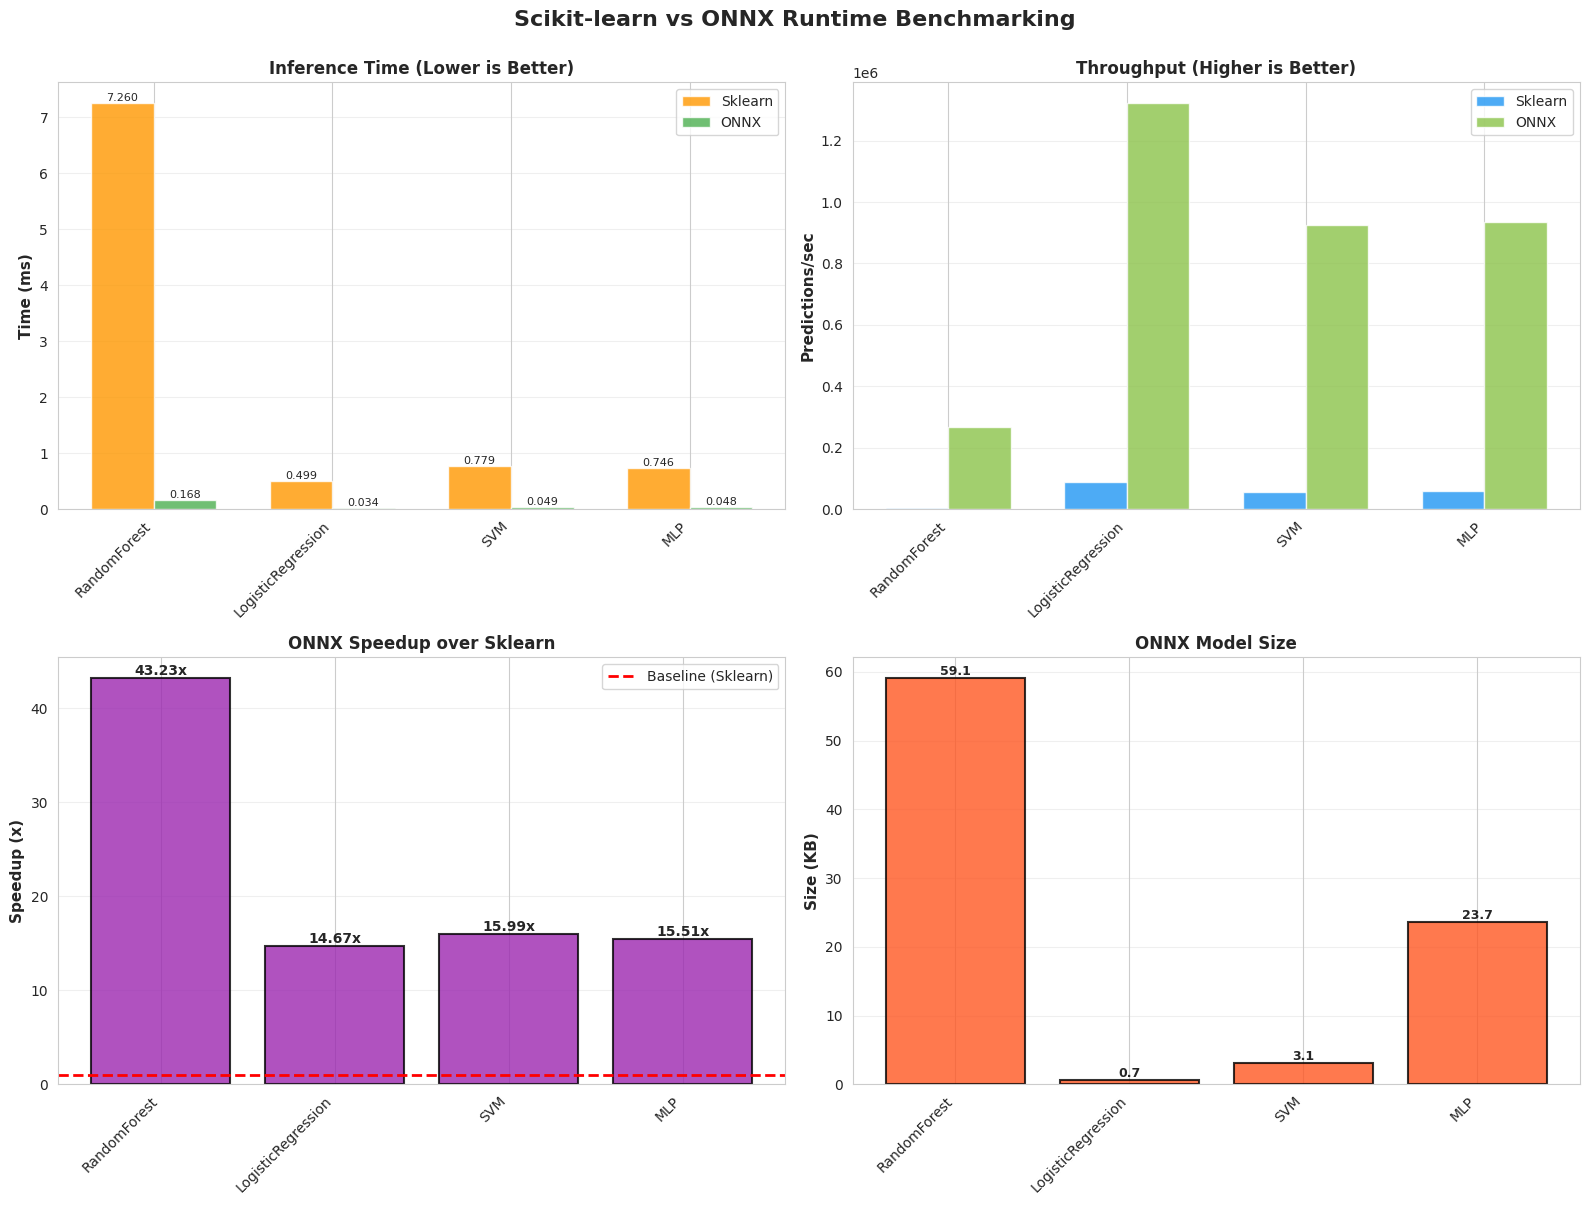


✅ Saved: results/sklearn_onnx_comparison.png


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Scikit-learn vs ONNX Runtime Benchmarking', fontsize=16, fontweight='bold', y=1.00)

model_names = list(sklearn_results.keys())
sklearn_times = [sklearn_results[m]['mean'] for m in model_names]
onnx_times = [onnx_results[m]['mean'] for m in model_names]
sklearn_throughputs = [sklearn_results[m]['throughput'] for m in model_names]
onnx_throughputs = [onnx_results[m]['throughput'] for m in model_names]
speedups = [sklearn_results[m]['mean'] / onnx_results[m]['mean'] for m in model_names]
model_sizes = [os.path.getsize(models_onnx[m]) / 1024 for m in model_names]

x = np.arange(len(model_names))
width = 0.35

# 1. Inference Time
bars1 = axes[0, 0].bar(x - width/2, sklearn_times, width, label='Sklearn', color='#FF9800', alpha=0.8)
bars2 = axes[0, 0].bar(x + width/2, onnx_times, width, label='ONNX', color='#4CAF50', alpha=0.8)
axes[0, 0].set_ylabel('Time (ms)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Inference Time (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Throughput
bars1 = axes[0, 1].bar(x - width/2, sklearn_throughputs, width, label='Sklearn', color='#2196F3', alpha=0.8)
bars2 = axes[0, 1].bar(x + width/2, onnx_throughputs, width, label='ONNX', color='#8BC34A', alpha=0.8)
axes[0, 1].set_ylabel('Predictions/sec', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Throughput (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Speedup
bars = axes[1, 0].bar(model_names, speedups, color='#9C27B0', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (Sklearn)')
axes[1, 0].set_ylabel('Speedup (x)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('ONNX Speedup over Sklearn', fontsize=12, fontweight='bold')
axes[1, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

for bar, speedup in zip(bars, speedups):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{speedup:.2f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Model Size
bars = axes[1, 1].bar(model_names, model_sizes, color='#FF5722', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Size (KB)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('ONNX Model Size', fontsize=12, fontweight='bold')
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

for bar, size in zip(bars, model_sizes):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{size:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('results/sklearn_onnx_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print('\n✅ Saved: results/sklearn_onnx_comparison.png')